<a href="https://colab.research.google.com/github/HakureiPOI/computer-vision-2025/blob/main/%E7%9C%9F%E5%A4%A7%E4%BD%9C%E4%B8%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
huanghanchina_pascal_voc_2012_path = kagglehub.dataset_download('huanghanchina/pascal-voc-2012')

print('Data source import complete.')


In [ ]:
!nvidia-smi

Fri May 23 15:17:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             28W /   70W |   10691MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!ls /kaggle/input/pascal-voc-2012/VOC2012

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [ ]:
base_path = '/kaggle/input/pascal-voc-2012/VOC2012'

In [ ]:
import numpy as np
from PIL import Image

def load_voc_images(path, train=True, max_num=None):
    txt_path = path + f'/ImageSets/Segmentation/{"train.txt" if train else "val.txt"}'
    with open(txt_path, 'r') as f:
        file_names = [x.strip() for x in f.readlines()]
    if max_num is not None:
        file_names = file_names[:min(len(file_names), max_num)]

    features, labels = [], []
    for idx, fname in enumerate(file_names):
        features.append(np.array(Image.open(path + f'/JPEGImages/{fname}.jpg').convert('RGB')))
        labels.append(np.array(Image.open(path + f'/SegmentationClass/{fname}.png').convert('RGB')))

    return features, labels

In [ ]:
def crop_images(features, labels, crop_size, tolerance=10, bg_threshold=0.75):
    cropped_features, cropped_labels = [], []

    for feature, label in zip(features, labels):
        h, w, _ = feature.shape
        if h <= crop_size[0] or w <= crop_size[1]:
            continue

        for _ in range(tolerance):
            start_h = np.random.randint(0, h - crop_size[0])
            start_w = np.random.randint(0, w - crop_size[1])

            crop_feat = feature[start_h:start_h + crop_size[0], start_w:start_w + crop_size[1], :]
            crop_label = label[start_h:start_h + crop_size[0], start_w:start_w + crop_size[1], :]

            bg_mask = np.all(crop_label == 0, axis=-1)
            bg_ratio = np.mean(bg_mask)

            if bg_ratio <= bg_threshold:
                cropped_features.append(crop_feat)
                cropped_labels.append(crop_label)
                break

    return np.array(cropped_features), np.array(cropped_labels)

In [ ]:
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
    [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    [0, 64, 128]
]

VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor'
]

In [ ]:
def build_colormap2label(colormap):
    cm2lbl = np.zeros(256 ** 3, dtype=np.uint8)
    for idx, color in enumerate(colormap):
        r, g, b = color
        cm2lbl[(r * 256 + g) * 256 + b] = idx
    return cm2lbl

cm2lbl = build_colormap2label(VOC_COLORMAP)

def voc_label_indices(label_img):
    data = label_img.astype('int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return cm2lbl[idx]

def convert_voc_rgb_labels(y_list):
    return np.array([voc_label_indices(y) for y in y_list])

In [ ]:
img_size = (256, 256)

In [ ]:
def load_voc_dataset(train=True, max_num=None, crop_size=img_size, bg_threshold=0.75):
    features, labels = load_voc_images(base_path, train=train, max_num=max_num)
    features_cropped, labels_cropped = crop_images(features, labels, crop_size=crop_size, bg_threshold=bg_threshold)
    features_cropped = features_cropped.astype('float32') / 255.0
    labels_cropped = convert_voc_rgb_labels(labels_cropped)

    return features_cropped, labels_cropped

In [ ]:
X_train, y_train = load_voc_dataset(train=True, max_num=2000, bg_threshold=0.75)
X_test, y_test = load_voc_dataset(train=False, max_num=1000, bg_threshold=1)

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

In [ ]:
# shape = X_train[0].shape

# X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 3))
# X_train_scaled = X_train_scaled.reshape(-1, *shape)

# X_test_scaled = scaler.transform(X_test.reshape(-1, 3)).reshape(-1, *shape)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1143, 256, 256, 3), (1143, 256, 256), (982, 256, 256, 3), (982, 256, 256))

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [ ]:
dataloaders = {'train':train_loader, 'val':test_loader}
dataset_sizes = {'train':len(train_dataset), 'val':len(test_dataset)}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device : {device}')

device : cuda


In [ ]:
import torch
from torch import optim, nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.models import resnet18

In [ ]:
num_classes = 21 # 21分类，1个背景，20个物体

In [ ]:
import torch.nn as nn
from torchvision.models import resnet18

# 加载预训练的 ResNet18
resnet = resnet18(pretrained=True)

# 冻结所有参数（作为特征提取器）
for param in resnet.parameters():
    param.requires_grad = False

# 构建模型：特征提取 + 1x1 分类器 + 上采样层
model_ft = nn.Sequential(
    *list(resnet.children())[:-2],                    # 输出 shape: [B, 512, H/32, W/32]
    nn.Conv2d(512, 21, kernel_size=1),                # 通道数调整为 21 类
    nn.ConvTranspose2d(21, 21, kernel_size=64,        # 上采样回原图大小
                       stride=32, padding=16, bias=False)
).to(device)

In [ ]:
import time
import copy

In [ ]:
def train_model(model: nn.Module, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    no_improve_epochs = 0  # 连续未提升的 epoch 数

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.long())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                running_corrects += torch.sum(preds == labels).item() / (img_size[0] * img_size[1])

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Early stopping 监控逻辑
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    no_improve_epochs = 0  # reset
                else:
                    no_improve_epochs += 1

        # 打印每个 epoch 完后的提示
        print()

        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
num_epochs = 20
learning_rate = 1e-3
lr_step_size = 3
lr_gamma = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=learning_rate)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

model_ft = train_model(model_ft, criterion, optimizer, lr_scheduler, num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 2.4489 Acc: 0.5196
val Loss: 1.8375 Acc: 0.6528

Epoch 1/19
----------
train Loss: 1.6894 Acc: 0.5930
val Loss: 1.1340 Acc: 0.7200

Epoch 2/19
----------
train Loss: 1.3421 Acc: 0.6524
val Loss: 1.0930 Acc: 0.7311

Epoch 3/19
----------
train Loss: 1.3028 Acc: 0.6606
val Loss: 1.0661 Acc: 0.7368

Epoch 4/19
----------
train Loss: 1.2684 Acc: 0.6669
val Loss: 1.0398 Acc: 0.7396

Epoch 5/19
----------
train Loss: 1.2474 Acc: 0.6694
val Loss: 1.0385 Acc: 0.7408

Epoch 6/19
----------
train Loss: 1.2483 Acc: 0.6692
val Loss: 1.0341 Acc: 0.7414

Epoch 7/19
----------
train Loss: 1.2417 Acc: 0.6713
val Loss: 1.0305 Acc: 0.7410

Epoch 8/19
----------
train Loss: 1.2398 Acc: 0.6718
val Loss: 1.0361 Acc: 0.7406

Epoch 9/19
----------
train Loss: 1.2396 Acc: 0.6719
val Loss: 1.0316 Acc: 0.7416

Epoch 10/19
----------
train Loss: 1.2349 Acc: 0.6734
val Loss: 1.0280 Acc: 0.7412

Epoch 11/19
----------
train Loss: 1.2394 Acc: 0.6729
val Loss: 1.0297 Acc: 0.7420

Ep

In [ ]:
def label2image(pred):
    colormap = torch.tensor(VOC_COLORMAP, device=device, dtype=int)
    x = pred.long()
    return (colormap[x,:]).data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device, num_images=3):
    model.eval()
    images_displayed = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.shape[0]):
                if images_displayed >= num_images:
                    return

                img = images[i].permute(1, 2, 0).cpu().numpy()  # [3,H,W] → [H,W,3]
                img = np.clip(img, 0, 1)

                label = label2image(labels[i])
                pred = label2image(preds[i])

                plt.figure(figsize=(10, 3))
                plt.subplot(1, 3, 1)
                plt.imshow(img)
                plt.title('Input Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(label)
                plt.title('Ground Truth')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred)
                plt.title('Prediction')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                images_displayed += 1


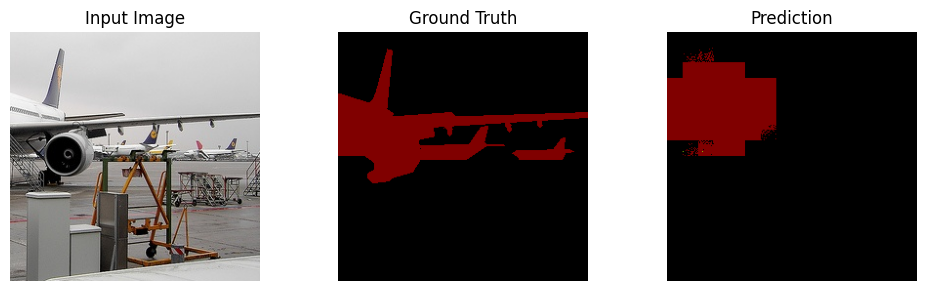

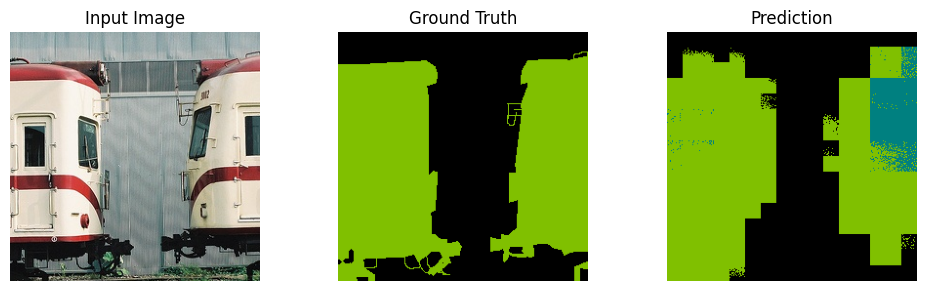

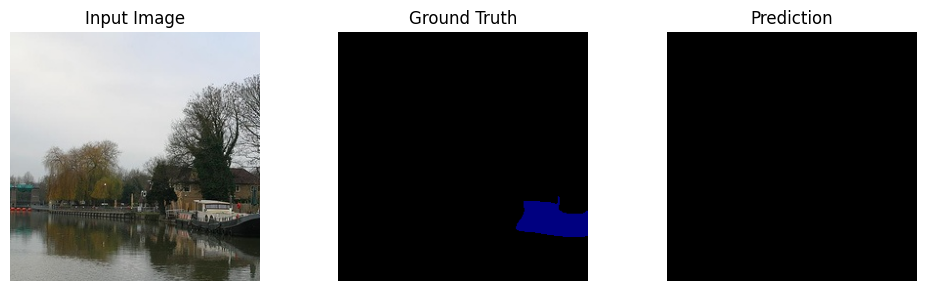

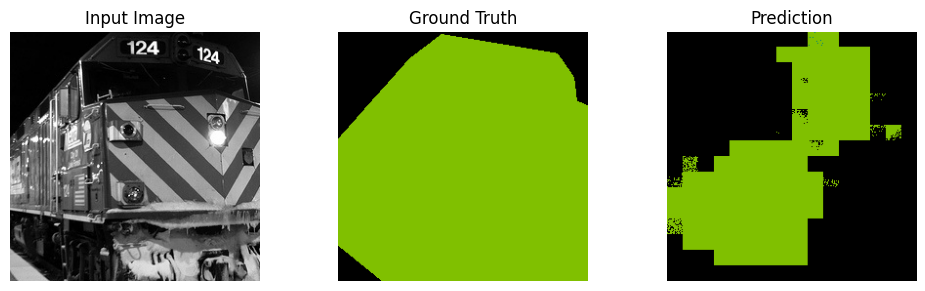

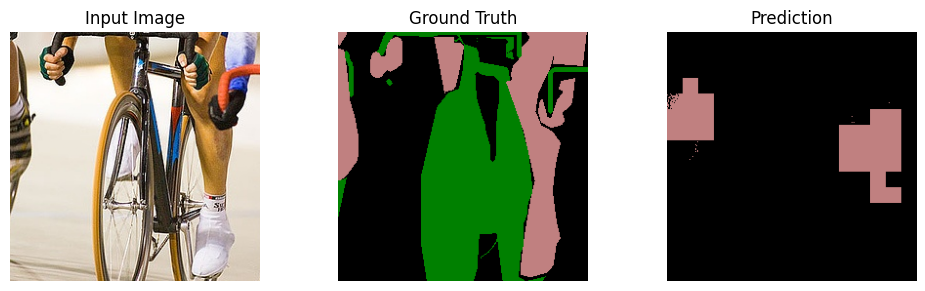

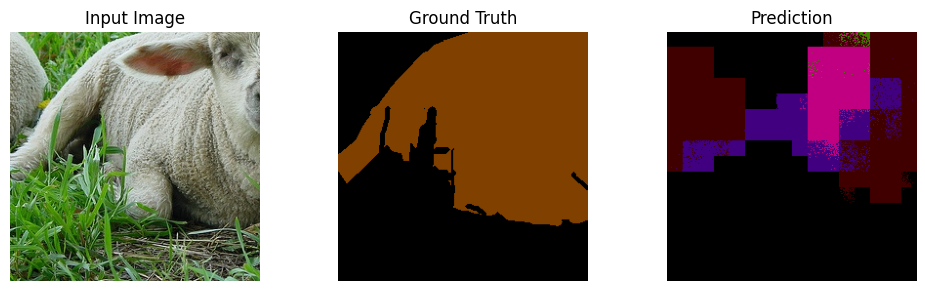

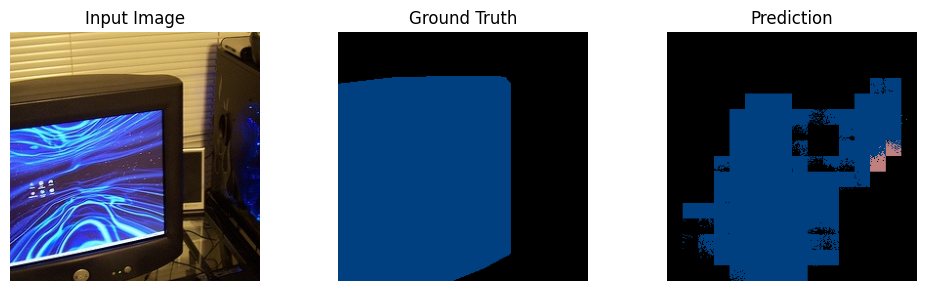

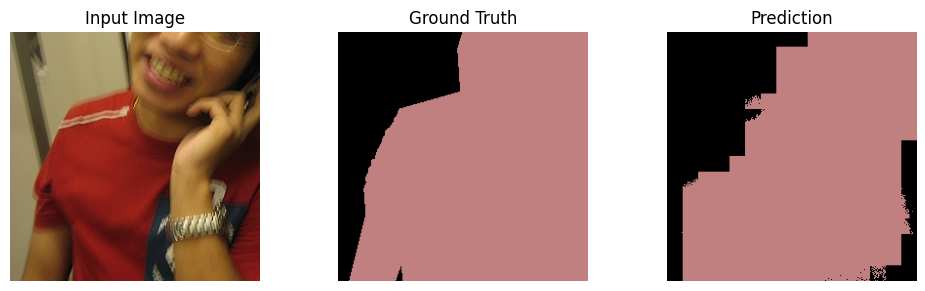

In [ ]:
visualize_predictions(model_ft, dataloaders['val'], device, num_images=10)